In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
from pathlib import Path
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import confusion_matrix, classification_report
from keras.optimizers import Adam, SGD, RMSprop
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import Callback, EarlyStopping
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt
import numpy as np
from scipy import ndimage, misc
import skimage
from keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
from zipfile import ZipFile
import os

# Dalam ini hal ini kami menggunakan data yg diupload ke google dribe probadi sehingga anda dapat mendownload datanya pada foler Data-Kaggle-Augmentation
# Ganti dengan path file zip Anda
zip_path = "/content/drive/MyDrive/Gano-Cat-Breeds-V1_1_FIX.zip"

# Ganti dengan path direktori tempat Anda ingin mengekstrak file
extract_path = "/content/drive/MyDrive"

with ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

print("File berhasil di-unzip di direktori:", extract_path)

File berhasil di-unzip di direktori: /content/drive/MyDrive


In [ ]:
filelist  = []

for dirname, _, filenames in os.walk('/content/drive/MyDrive/Gano-Cat-Breeds-V1_1_FIX'):
    for filename in filenames:
        filelist.append (os.path.join(dirname, filename))

In [ ]:
labels_needed = ['Abyssinian', 'American Bobtail', 'American Shorthair', 'Bengal', 'Birman', 'Bombay', 'British Shorthair', 'Egyptian Mau', 'Maine Coon', 'Persian',
                 'Ragdoll', 'Russian Blue', 'Siamese', 'Sphynx', 'Tuxedo']

In [ ]:
Filepaths   = []
labels = []

for image_file in filelist:
    label = image_file.split(os.path.sep)[-2]
    if label in labels_needed:

        Filepaths.append(image_file)
        labels.append(label)

x = np.array(Filepaths)
y = np.array(labels)

In [ ]:
set(labels_needed)

{'Abyssinian',
 'American Bobtail',
 'American Shorthair',
 'Bengal',
 'Birman',
 'Bombay',
 'British Shorthair',
 'Egyptian Mau',
 'Maine Coon',
 'Persian',
 'Ragdoll',
 'Russian Blue',
 'Siamese',
 'Sphynx',
 'Tuxedo'}

In [ ]:
import glob
path = '/content/drive/MyDrive/Gano-Cat-Breeds-V1_1_FIX'
path_imgs = list(glob.glob(path+'/**/*.jpg') + glob.glob(path+'/**/*.png'))

In [ ]:
len(path_imgs)

11250

In [ ]:
labels = list(map(lambda x:os.path.split(os.path.split(x)[0])[1], path_imgs))
file_path = pd.Series(path_imgs, name='File_Path').astype(str)
labels = pd.Series(labels, name='Labels')
data = pd.concat([file_path, labels], axis=1)
data = data.sample(frac=1).reset_index(drop=True)
data.head()

,File_Path,Labels
0,/content/drive/MyDrive/Gano-Cat-Breeds-V1_1_FI...,Siamese
1,/content/drive/MyDrive/Gano-Cat-Breeds-V1_1_FI...,Persian
2,/content/drive/MyDrive/Gano-Cat-Breeds-V1_1_FI...,Abyssinian
3,/content/drive/MyDrive/Gano-Cat-Breeds-V1_1_FI...,American Shorthair
4,/content/drive/MyDrive/Gano-Cat-Breeds-V1_1_FI...,Tuxedo


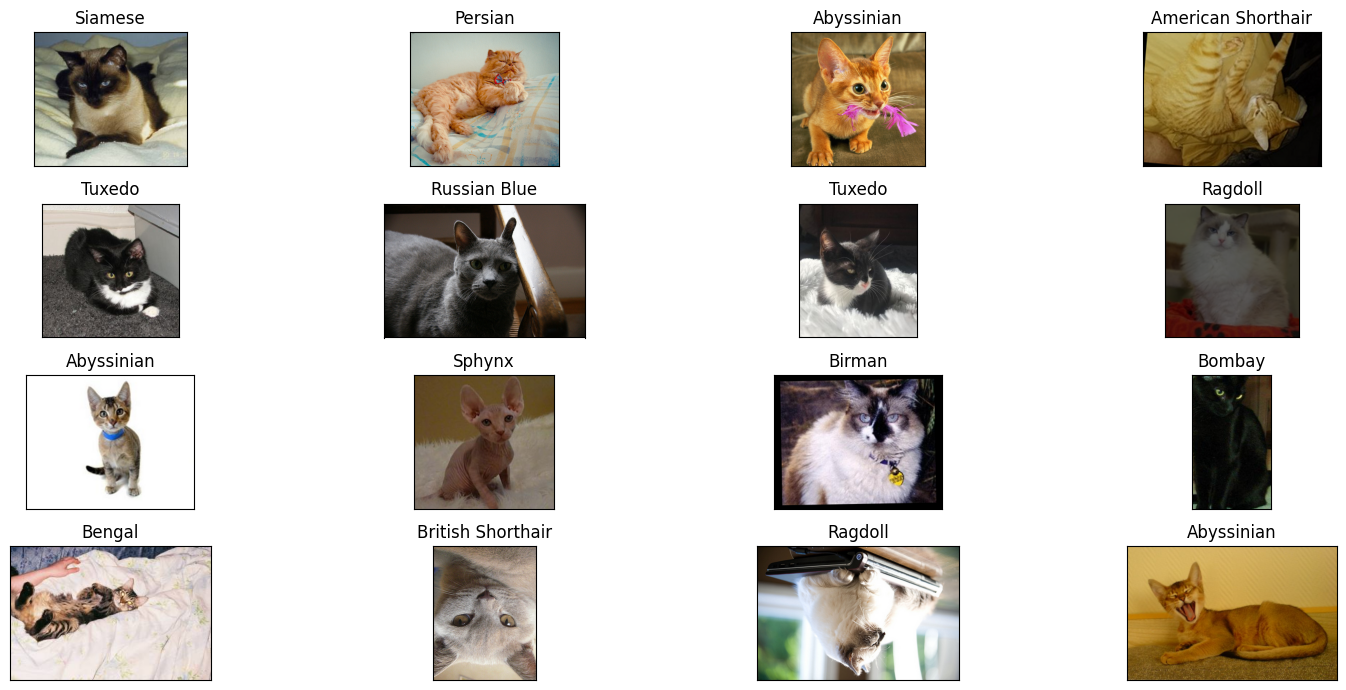

In [ ]:
fig, axes = plt.subplots(nrows=4, ncols=4, figsize=(16, 7),
                        subplot_kw={'xticks': [], 'yticks': []})
for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(data.File_Path[i]))
    ax.set_title(data.Labels[i])
plt.tight_layout()
plt.show()

In [ ]:
train_df, valid_df = train_test_split(data, test_size=0.2, random_state=2)

In [ ]:
from keras.preprocessing.image import ImageDataGenerator

def gen(pre, train, valid):
    train_datagen = ImageDataGenerator(
        preprocessing_function=pre,
        rotation_range=30,
        zoom_range=0.15,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.15,
        horizontal_flip=True,
        fill_mode="nearest"
    )
    valid_datagen = ImageDataGenerator(
        preprocessing_function=pre,
        rotation_range=30,
        zoom_range=0.15,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.15,
        horizontal_flip=True,
        fill_mode="nearest"
    )

    train_gen = train_datagen.flow_from_dataframe(
        dataframe=train,
        x_col='File_Path',
        y_col='Labels',
        target_size=(224, 224),
        class_mode='categorical',
        batch_size=32,
        shuffle=True,
        seed=0
    )
    valid_gen = valid_datagen.flow_from_dataframe(
        dataframe=valid,
        x_col='File_Path',
        y_col='Labels',
        target_size=(224, 224),
        class_mode='categorical',
        batch_size=32,
        shuffle=False,
        seed=0
    )

    return train_gen, valid_gen

In [ ]:
from tensorflow.keras.callbacks import LearningRateScheduler
from tensorflow.keras.regularizers import l2


def func(name_model):
    pre_model = name_model(input_shape=(224, 224, 3),
                           include_top=False,
                           weights='imagenet',
                           pooling='avg')

    # Membuka kembali beberapa layer terakhir dari model dasar (tuning)
    for layer in pre_model.layers[-20:]:
        layer.trainable = True

    inputs = pre_model.input
    # Menambahkan regularisasi L2
    x = Dense(256, activation='relu', kernel_regularizer=l2(0.01))(pre_model.output)
    x = Dropout(0.3)(x)  # Menambahkan layer Dropout
    x = Dense(256, activation='relu')(x)
    outputs = Dense(15, activation='softmax')(x)
    model = Model(inputs=inputs, outputs=outputs)

    # LearningRateScheduler
    def lr_schedule(epoch):
        lr = 1e-3
        if epoch > 10:
            lr *= 0.1
        return lr

    lr_scheduler = LearningRateScheduler(lr_schedule)

    model.compile(loss='categorical_crossentropy', optimizer='Adam', metrics=['accuracy'])
    my_callbacks = [lr_scheduler]

    return model, my_callbacks


In [ ]:
def plot(history,valid_gen,train_gen,model):
    # Plotting Accuracy, val_accuracy, loss, val_loss
    fig, ax = plt.subplots(1, 2, figsize=(10, 3))
    ax = ax.ravel()

    for i, met in enumerate(['accuracy', 'loss']):
        ax[i].plot(history.history[met])
        ax[i].plot(history.history['val_' + met])
        ax[i].set_title('Model {}'.format(met))
        ax[i].set_xlabel('epochs')
        ax[i].set_ylabel(met)
        ax[i].legend(['Train', 'Validation'])

        # Predict Data Test
    pred = model.predict(valid_gen)
    pred = np.argmax(pred,axis=1)
    labels = (train_gen.class_indices)
    labels = dict((v,k) for k,v in labels.items())
    pred = [labels[k] for k in pred]

    # Classification report
    cm=confusion_matrix(valid_df.Labels,pred)
    clr = classification_report(valid_df.Labels, pred)
    print(clr)
    # Display 6 picture of the dataset with their labels
    fig, axes = plt.subplots(nrows=4, ncols=3, figsize=(16, 8),
                        subplot_kw={'xticks': [], 'yticks': []})

    for i, ax in enumerate(axes.flat):
        ax.imshow(plt.imread(valid_df.File_Path.iloc[i+1]))
        ax.set_title(f"True: {valid_df.Labels.iloc[i+1]}\nPredicted: {pred[i+1]}")
    plt.tight_layout()
    plt.show()

    return history

In [ ]:
def result_test(valid,model_use):
    results = model_use.evaluate(valid, verbose=0)

    print("Validation Loss: {:.5f}".format(results[0]))
    print("Validation Accuracy: {:.2f}%".format(results[1] * 100))

    return results

In [ ]:
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.applications.efficientnet import preprocess_input

EfficientNetB0_pre=preprocess_input
train_gen_EfficientNetB0, valid_gen_EfficientNetB0 = gen(EfficientNetB0_pre, train_df, valid_df)
EfficientNetB0_model, callback=func(EfficientNetB0)
history = EfficientNetB0_model.fit(
    train_gen_EfficientNetB0,
    validation_data=valid_gen_EfficientNetB0,
    epochs=20,
    callbacks=callback,
    verbose=1)

Found 9000 validated image filenames belonging to 15 classes.
Found 2250 validated image filenames belonging to 15 classes.
16705208/16705208 [==============================] - 0s 0us/step
Epoch 1/20
282/282 [==============================] - 280s 839ms/step - loss: 2.2346 - accuracy: 0.6212 - val_loss: 1.3394 - val_accuracy: 0.6622 - lr: 0.0010
Epoch 2/20
282/282 [==============================] - 269s 956ms/step - loss: 1.0025 - accuracy: 0.7344 - val_loss: 0.9488 - val_accuracy: 0.7413 - lr: 0.0010
Epoch 3/20
282/282 [==============================] - 236s 837ms/step - loss: 0.8824 - accuracy: 0.7658 - val_loss: 1.1538 - val_accuracy: 0.7013 - lr: 0.0010
Epoch 4/20
282/282 [==============================] - 235s 833ms/step - loss: 0.7923 - accuracy: 0.7860 - val_loss: 0.9300 - val_accuracy: 0.7484 - lr: 0.0010
Epoch 5/20
282/282 [==============================] - 272s 965ms/step - loss: 0.7584 - accuracy: 0.8009 - val_loss: 0.9347 - val_accuracy: 0.7360 - lr: 0.0010
Epoch 6/20
282/2

71/71 [==============================] - 43s 589ms/step
                    precision    recall  f1-score   support

        Abyssinian       0.91      0.92      0.91       158
  American Bobtail       0.77      0.73      0.75       163
American Shorthair       0.82      0.78      0.80       152
            Bengal       0.93      0.93      0.93       150
            Birman       0.84      0.91      0.88       147
            Bombay       0.94      0.99      0.96       143
 British Shorthair       0.91      0.89      0.90       166
      Egyptian Mau       0.92      0.87      0.89       161
        Maine Coon       0.93      0.95      0.94       147
           Persian       0.99      0.96      0.97       139
           Ragdoll       0.91      0.89      0.90       153
      Russian Blue       0.92      0.98      0.95       135
           Siamese       0.97      0.94      0.95       118
            Sphynx       1.00      0.99      1.00       164
            Tuxedo       0.96      1.00    

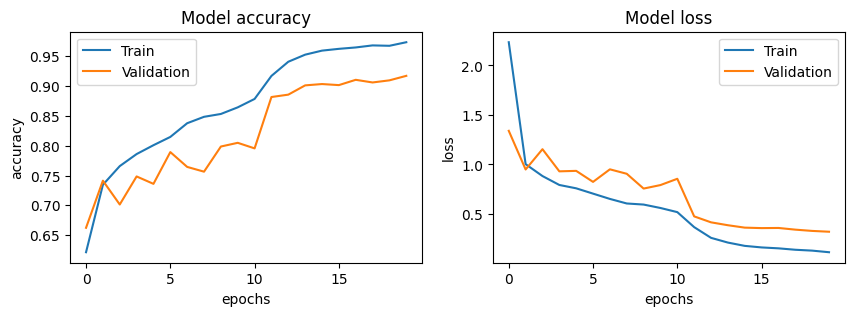

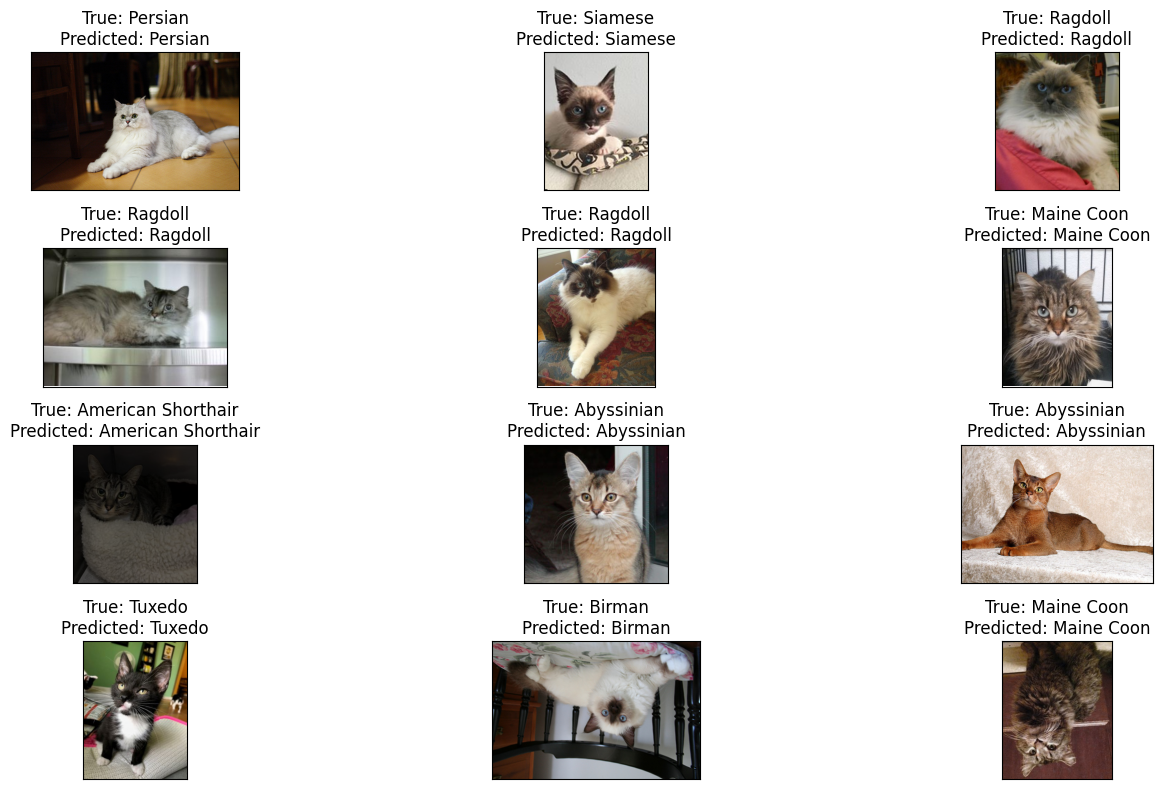

Validation Loss: 0.32034
Validation Accuracy: 91.69%


In [ ]:
history_EfficientNetB0 = plot(history, valid_gen_EfficientNetB0, train_gen_EfficientNetB0, EfficientNetB0_model)

result_EfficientNetB0 = result_test(valid_gen_EfficientNetB0, EfficientNetB0_model)

1/1 [==============================] - 0s 57ms/step


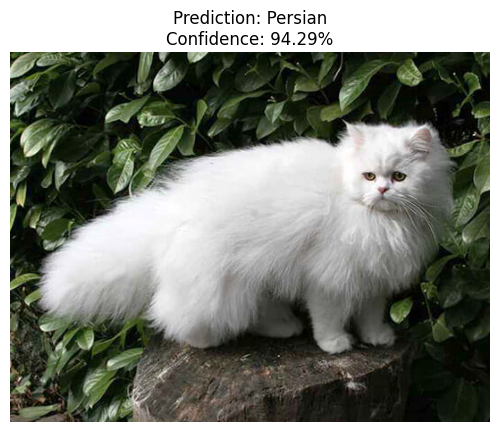

In [ ]:
import cv2
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image
import numpy as np

# Function to preprocess input image
def preprocess_input_image(img_path):
    img = image.load_img(img_path, target_size=(224, 224))
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = preprocess_input(img_array)  # Assuming you used preprocess_input during training
    return img_array

# Function to display results
def display_results(img_path, predictions, labels):
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    plt.imshow(img)
    plt.axis('off')

    predicted_label = labels[np.argmax(predictions)]
    confidence = predictions[0][np.argmax(predictions)] * 100

    plt.title(f'Prediction: {predicted_label}\nConfidence: {confidence:.2f}%')
    plt.show()

# Assuming you have a list of class labels
class_labels = ['Abyssinian', 'American Bobtail', 'American Shorthair', 'Bengal', 'Birman', 'Bombay', 'British Shorthair', 'Egyptian Mau', 'Maine Coon', 'Persian',
                 'Ragdoll', 'Russian Blue', 'Siamese', 'Sphynx', 'Tuxedo']

# Image path for testing (replace with the actual path to the uploaded image)
image_path_to_predict = "persian-doll-face.jpg"

# Run the prediction
predictions = EfficientNetB0_model.predict(preprocess_input_image(image_path_to_predict))

# Display the results
display_results(image_path_to_predict, predictions, class_labels)


In [ ]:
# Save the model
model_save_path = 'path/EfficientNet_model_cat_prediction.h5'
EfficientNetB0_model.save(model_save_path)

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
